<a href="https://colab.research.google.com/github/KatyaHY/AmortizationSchedule/blob/main/Maman3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
import pdb
from tqdm import tqdm

In [19]:
data = pd.read_csv('diabetes.csv', sep='\t')
deciles = pd.qcut(data['Y'], 10, labels=False)

In [20]:
data['Class'] = (deciles+1)

In [21]:
# יצירת מערך מסדר רנדומלי של מספרי שורות
rows = np.random.permutation(data.index)

# חילוק המערך המסדר רנדומלי לשני מערכים באורכים של 80% ו-20%
train_rows = rows[:int(len(rows)*0.8)]
test_rows = rows[int(len(rows)*0.8):]

# יצירת DataFrame חדשות עבור קבוצות השורות
train_data = data.iloc[train_rows]
test_data = data.iloc[test_rows]

In [22]:
class DiabetesDataset(Dataset):
  def __init__(self, data, deciles, Y_info_included=True):
    self.data = data
    self.targets = deciles
    if Y_info_included:
      self.inputs = self.data.drop(columns='Class')
    else:
      self.inputs = self.data.drop(columns=['Y','Class'])
    
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, idx):
    x = torch.tensor(self.inputs.iloc[idx], dtype=torch.float32)
    y = torch.tensor(self.targets.iloc[idx])
    return x, y

In [23]:
train_dataset = DiabetesDataset(train_data, deciles, False)
test_dataset = DiabetesDataset(test_data, deciles, False)

In [24]:
train_dataset = DiabetesDataset(train_data, deciles, True)
test_dataset = DiabetesDataset(test_data, deciles, True)

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
iterator = iter(train_dataloader)
batch, label = next(iterator)
print(batch)

tensor([[ 67.0000,   1.0000,  29.8000,  80.0000, 172.0000,  93.4000,  63.0000,
           3.0000,   4.3567,  82.0000,  90.0000],
        [ 39.0000,   2.0000,  26.3000, 115.0000, 218.0000, 158.2000,  32.0000,
           7.0000,   4.9345, 109.0000, 292.0000],
        [ 58.0000,   2.0000,  38.0000, 103.0000, 150.0000, 107.2000,  22.0000,
           7.0000,   4.6444,  98.0000, 341.0000],
        [ 38.0000,   1.0000,  27.3000,  81.0000, 146.0000,  81.6000,  47.0000,
           3.0000,   4.4659,  81.0000, 210.0000],
        [ 54.0000,   2.0000,  36.1000, 115.0000, 163.0000,  98.4000,  43.0000,
           4.0000,   4.6821, 101.0000, 321.0000],
        [ 60.0000,   2.0000,  24.9000,  99.6700, 162.0000, 106.6000,  43.0000,
           3.7700,   4.1271,  95.0000, 132.0000],
        [ 43.0000,   1.0000,  28.1000, 121.0000, 192.0000, 121.0000,  60.0000,
           3.0000,   4.0073,  93.0000, 113.0000],
        [ 34.0000,   1.0000,  26.3000,  87.0000, 197.0000, 120.0000,  63.0000,
           3.0000,

In [26]:
model = nn.Sequential(
    nn.Linear(11,20),
    nn.ReLU(),
    nn.Linear(20,10),
    nn.ReLU(),
    nn.Linear(10,10),
    nn.ReLU(),
    nn.Linear(10,10), 
    nn.LogSoftmax(dim=1)
)
print(model)

Sequential(
  (0): Linear(in_features=11, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


In [27]:
def reset_model_params():
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

In [28]:
CE_loss = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [29]:
def iterate_batch(features, labels):
  optimizer.zero_grad()
  y_model = model(features)
  
  loss = CE_loss(y_model,labels)
  loss.backward()
  optimizer.step()
  
  predicted_labels = y_model.argmax(dim=1)
  acc = (predicted_labels == labels).sum() / len(labels)
  return loss.detach(), acc.detach()

In [30]:
def iterate_epoch():
    running_loss = 0.
    running_acc  = 0.
    for idx, (features, labels) in enumerate(train_dataloader):
      batch_loss, batch_acc, = iterate_batch(features, labels)
      running_loss += batch_loss
      running_acc  += batch_acc
    loss = running_loss/batches
    acc  = running_acc/batches
    return loss, acc

In [31]:
def eval_model_test():
  loss = 0.
  acc  = 0.
  test_batches = len(test_dataloader)
  for idx, (features, labels) in enumerate(test_dataloader):
    with torch.no_grad():
      y_model = model(features) 
      loss   += CE_loss(y_model, labels)
      predicted_labels = y_model.argmax(dim=1)
      acc += (predicted_labels == labels).sum() / len(labels)
  return loss/test_batches, acc/test_batches

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)
epochs=100
batches = len(train_dataloader)
loss_train = torch.zeros(epochs)
acc_train = torch.zeros(epochs)
loss_test = torch.zeros(epochs)
acc_test = torch.zeros(epochs)

reset_model_params()

for epoch_idx in tqdm(range(epochs)):
  loss_train[epoch_idx], acc_train[epoch_idx] = iterate_epoch()
  loss_test[epoch_idx],  acc_test[epoch_idx] = eval_model_test()

100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


<Figure size 1200x400 with 0 Axes>

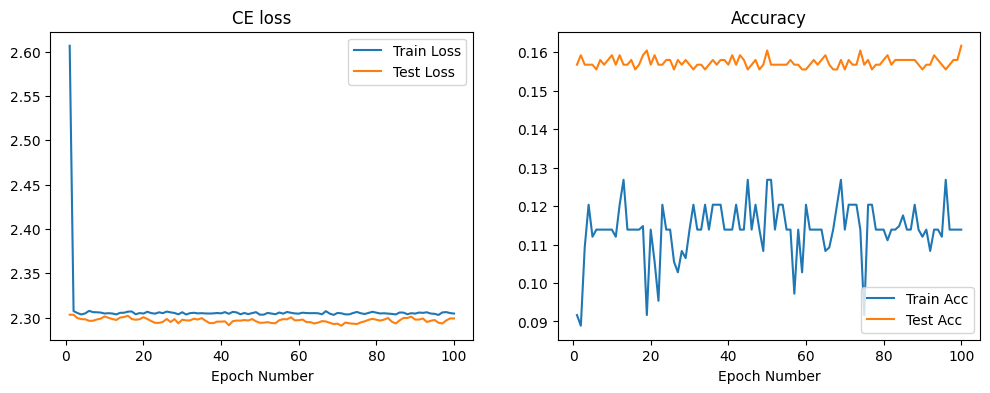

In [33]:
plt.figure(figsize=(12,4))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,epochs+1), loss_train, label="Train Loss");
plt.plot(range(1,epochs+1), loss_test, label="Test Loss");
plt.title("CE loss");
plt.legend()
plt.xlabel("Epoch Number");
plt.subplot(1,2,2)
plt.plot(range(1,epochs+1), acc_train, label="Train Acc");
plt.plot(range(1,epochs+1), acc_test, label="Test Acc");
plt.title("Accuracy");
plt.legend()
plt.xlabel("Epoch Number");